# Regression with Neural network

In this file, we create a neural network with one hidden layer and apply it to the PM2.5 data for the regression task. We also compute uncertainty estimates based on the dropout neural network model.

In [1]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.datasets import mnist
from keras.optimizers import RMSprop
from keras import regularizers

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt

import os
from tqdm import tqdm
import pandas as pd

from utils_classifNN import *



Using TensorFlow backend.


In [2]:
path = 'data/FiveCitiePMData'

"""
data = []
for f in os.listdir(path):
    print(f)
    data.append(pd.read_csv(path + '/'+ f))
"""

"\ndata = []\nfor f in os.listdir(path):\n    print(f)\n    data.append(pd.read_csv(path + '/'+ f))\n"

## Cleaning the dataset 

We will try to make a regression on the PM_US Post values with some continuous and categorical variables in the dataset

In [3]:
beijing = pd.read_csv(path + '/' + 'BeijingPM20100101_20151231.csv')
print(list(beijing))
np.sum(pd.isna(beijing['PM_Nongzhanguan']))
# removing the 
missing_uspost = [not(e) for e in list(pd.isna(beijing['PM_US Post'], ))]
beijing_cl = beijing[missing_uspost]
beijing_cl = pd.DataFrame(beijing_cl)

#features = ['DEWP', 'HUMI', 'PRES', 'TEMP','Iws', 'precipitation', 'Iprec'] # w
features = ['year', 'month', 'day', 'hour', 'season', 'DEWP', 'HUMI', 'PRES', 'TEMP','Iws', 'precipitation', 'Iprec']

['No', 'year', 'month', 'day', 'hour', 'season', 'PM_Dongsi', 'PM_Dongsihuan', 'PM_Nongzhanguan', 'PM_US Post', 'DEWP', 'HUMI', 'PRES', 'TEMP', 'cbwd', 'Iws', 'precipitation', 'Iprec']


In [4]:
# check for nas
for e in features:
    print(e, ':', np.sum(pd.isna(beijing_cl[e])), 'nas')

year : 0 nas
month : 0 nas
day : 0 nas
hour : 0 nas
season : 0 nas
DEWP : 5 nas
HUMI : 339 nas
PRES : 339 nas
TEMP : 5 nas
Iws : 5 nas
precipitation : 473 nas
Iprec : 473 nas


In [5]:
# removing the rows for which there are NA
beijing_cl2 = beijing_cl[['No'] + features + ['PM_US Post']].dropna(how = 'any')

#print(beijing_cl2.describe())
X_df = beijing_cl2[features]
y_df = beijing_cl2['PM_US Post']

In [6]:
# checking another time for nas
for e in features:
    print(e, ':', np.sum(pd.isna(X_df[e])), "nas")

print('PM_US Post :', np.sum(pd.isna(y_df)), 'nas')

year : 0 nas
month : 0 nas
day : 0 nas
hour : 0 nas
season : 0 nas
DEWP : 0 nas
HUMI : 0 nas
PRES : 0 nas
TEMP : 0 nas
Iws : 0 nas
precipitation : 0 nas
Iprec : 0 nas
PM_US Post : 0 nas


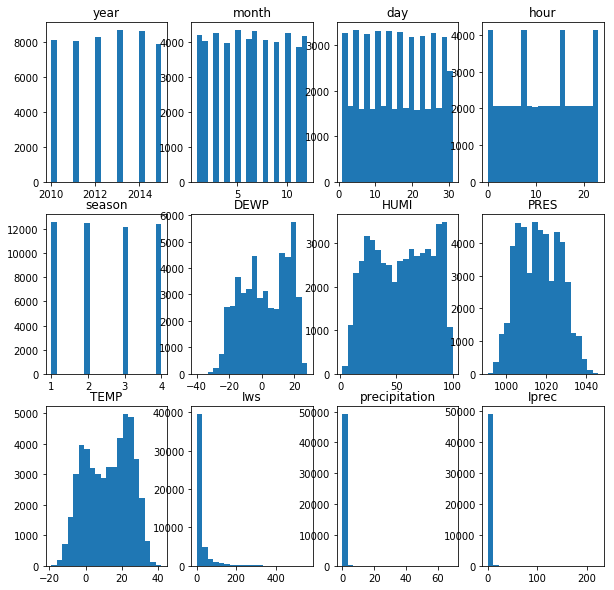

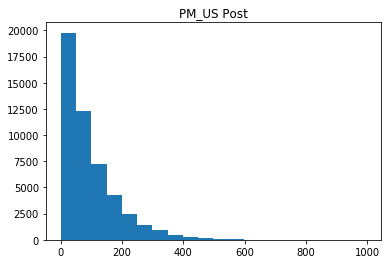

In [7]:
plt.figure(figsize= (10,10))

for i,e in enumerate(list(X_df)):
    plt.subplot(3,4,i+1)
    plt.hist(X_df[e], bins = 20)
    plt.title(e)
plt.show()

plt.hist(y_df, bins = 20)
plt.title("PM_US Post")
plt.show()

In [8]:
# converting to numpy arrays
X = X_df.values
y = y_df.values

In [9]:
nb_samples = 1500
X_train, X_test, y_train, y_test = train_test_split(X[:nb_samples,], y[:nb_samples,], test_size = 0.2, shuffle = False)
y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))
print('X train shape: ', X_train.shape)
print('y train shape: ', y_train.shape)
print('X test shape: ', X_test.shape)
print('y test shape: ', y_test.shape)

X train shape:  (1200, 12)
y train shape:  (1200, 1)
X test shape:  (300, 12)
y test shape:  (300, 1)


In [10]:
X_train_scale = scale(X_train)
y_train_scale = scale(y_train)
X_test_scale = scale(X_test)
y_test_scale = scale(y_test)

In [81]:
# network parameters
batch_size = 32
num_classes = 1 # here we are doing a regression over an output with 1 dimension only
epochs = 50

# dimensions for the NN:
# input dimension
Q = X_train_scale.shape[1]
# hidden layer dimension
K = 100
# output dimension : regression
D = num_classes

# dropout rate
DROP_OUT = 0.2

N = X_train_scale.shape[0]
# l2 regularization
lambd = 0.01
# precision parameter
TAU = DROP_OUT/(2*lambd*N)
print(N,TAU)

1200 0.008333333333333333


## Create a sequential model with Keras 

In [82]:
model = Sequential()
model.add(Dense(K, input_shape = (Q, ), activation = 'relu', use_bias= True, kernel_regularizer = regularizers.l2(lambd),
               bias_regularizer = regularizers.l2(lambd)))
model.add(Dropout(DROP_OUT))

model.add(Dense(num_classes, use_bias = False, activation = None, kernel_regularizer = regularizers.l2(lambd)))
model.add(Dropout(DROP_OUT))
model.add(Activation('linear'))

In [93]:
from keras.optimizers import SGD, Adam

model.summary()
adam = Adam(lr=0.005)
model.compile(loss='mean_squared_error',
              optimizer=adam,
              metrics=['mse'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 100)               1300      
_________________________________________________________________
dropout_9 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 100       
_________________________________________________________________
dropout_10 (Dropout)         (None, 1)                 0         
_________________________________________________________________
activation_5 (Activation)    (None, 1)                 0         
Total params: 1,400
Trainable params: 1,400
Non-trainable params: 0
_________________________________________________________________


In [94]:
# Training the network
history = model.fit(X_train_scale, y_train_scale,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_train_scale, y_train_scale))


Train on 1200 samples, validate on 1200 samples
Epoch 1/50
1200/1200 [==============================] - 1s 614us/step - loss: 0.5962 - mean_squared_error: 0.5202 - val_loss: 0.4938 - val_mean_squared_error: 0.4299
Epoch 2/50
1200/1200 [==============================] - 0s 91us/step - loss: 0.5622 - mean_squared_error: 0.5019 - val_loss: 0.4697 - val_mean_squared_error: 0.4113
Epoch 3/50
1200/1200 [==============================] - 0s 110us/step - loss: 0.5843 - mean_squared_error: 0.5304 - val_loss: 0.4560 - val_mean_squared_error: 0.4048
Epoch 4/50
1200/1200 [==============================] - 0s 149us/step - loss: 0.5475 - mean_squared_error: 0.4964 - val_loss: 0.4600 - val_mean_squared_error: 0.4106
Epoch 5/50
1200/1200 [==============================] - 0s 92us/step - loss: 0.5746 - mean_squared_error: 0.5251 - val_loss: 0.4651 - val_mean_squared_error: 0.4168
Epoch 6/50
1200/1200 [==============================] - 0s 114us/step - loss: 0.5907 - mean_squared_error: 0.5435 - val_loss

Epoch 50/50
1200/1200 [==============================] - 0s 133us/step - loss: 0.5625 - mean_squared_error: 0.5165 - val_loss: 0.4278 - val_mean_squared_error: 0.3818


In [95]:
# Evaluation of the network
score = model.evaluate(X_test_scale, y_test_scale, verbose = 0)
print('Test loss:', score[0])
print('Test mean squared error:', score[1])

Test loss: 0.639576924642
Test mean squared error: 0.593567995032


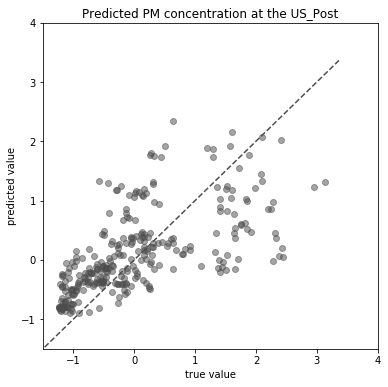

In [96]:
#plt.plot(y_test, color ='red')

y_pred = model.predict(X_test_scale)
#plt.plot(y_pred, color='b')
#plt.plot(y_test,y_pred, 'p', alpha = 0.2)
#plt.plot(plt.get_xlim(), plt.get_ylim(), ls="--", c=".3")
#plt.show()

f, ax = plt.subplots(figsize=(6, 6))
ax.scatter(y_test_scale, y_pred, c=".3", alpha = 0.5)
ax.plot(ax.get_xlim(), ax.get_xlim(), ls="--", c=".3")
ax.set_xlim(-1.5,4)
ax.set_ylim(-1.5,4)
ax.set_xlabel('true value')
ax.set_ylabel('predicted value')
plt.title("Predicted PM concentration at the US_Post")
plt.show()

## Obtaining model uncertainty

We use the equation 4, 5 of the report to compute the mean and standard error based 
on the network parameters and T forward passes in the network.

In [97]:
""""
auxilary function to compute the the 100 forward passes in the network
input:  x, the point to predict
        model, the trained neural network
        drop the dropout rate
        T, the number of forwad passes
output: a sample of T predictions
"""
def reg_dropout_sample(x, model, drop, T = 100) :
    W1, b, W2 = model.get_weights()
    pred_sample = np.zeros(T)
    
    for i in range(T):
        z1 = np.diag(np.random.rand(W1.shape[0]) > drop)
        z2 = np.diag(np.random.rand(W2.shape[0]) > drop)
        pred = np.dot(my_relu(np.dot(x, np.dot(z1, W1)) + b), np.dot(z2, W2)) 
        pred_sample[i] = pred
    return pred_sample

""""
Return the mean of the prediction in the review as well as the standard deviation computed with equations 4 and 5.
input:  x, the point to predict
        model, the trained neural network
        drop, the dropout rate for the network layers
        tau, the preicision parameter (tau = drop/())
        T, the number of forwad passes
output: a prediction mean averaged over the T forward passes and the sd
"""
def reg_mean_sd(x, model, drop, tau, T = 100):
    sample = reg_dropout_sample(x, model, drop, T =T)
    avg = np.mean(sample)
    sd = (tau + np.mean(np.array([e**2 for e in sample])))**2
    return avg, sd

In [98]:
ix = 0 
m, sd = reg_mean_sd(X_test_scale[ix], model = model, drop = DROP_OUT, tau = TAU)
print('prediction: ', m)
print('standard deviation: ', sd)

prediction:  0.444405836559
standard deviation:  0.0720820389232


## Plot the prediction and uncertainty against time

In [99]:
y_pred = np.zeros(X_test_scale.shape[0])
sd_pred = np.zeros_like(y_pred)
for i,xx in tqdm(enumerate(X_test_scale)):
    y_pred[i], sd_pred[i] = reg_mean_sd(x = xx, model = model, drop=DROP_OUT, tau= TAU)

300it [00:01, 202.03it/s]


In [100]:
X_testdf = pd.DataFrame(X_test)
date_x_test = pd.to_datetime((X_testdf[0]*1000000+X_testdf[1]*10000+X_testdf[2]*100+X_testdf[3]).astype(int).apply(str),format='%Y%m%d%H')
Y_preddf = pd.DataFrame(np.array(y_pred))
Y_preddf['date'] = date_x_test
Y_preddf = Y_preddf.sort_values('date', ascending=True)

Y_testdf = pd.DataFrame(np.array(y_test_scale))
Y_testdf['date'] = date_x_test
Y_testdf = Y_testdf.sort_values('date', ascending=True)


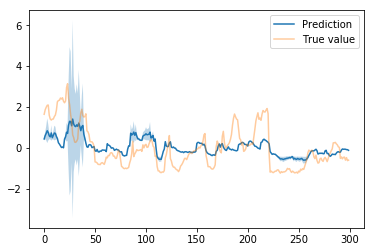

In [101]:
plt.plot(Y_preddf[0], label="Prediction")
plt.plot(Y_testdf[0], alpha=0.4, label="True value")

plt.fill_between(np.arange(300), Y_preddf[0]+sd_pred, Y_preddf[0]-sd_pred, alpha=0.3)

plt.legend()
plt.show()